## Рекламные данные 

### Задачи: 

Необходимо провести разведовательный анализ и оценить, если ли стат. различие между средним значением CTR для оплаты за клик(CPC) и за промотры(CPM), а также в разбивке по платформам 

## Summary 

1. Провела предобработку данных, рассчитала CTR  


2. Визуализировала данные по ctr в зависимости от типа оплаты с помощью boxplot и distplot  


3. Полученное ассиметричное распределение оказалось log-нормальным  


4. Прологарифмировала и после провела t-test для сравнения двух групп (т.к. критерии для теста Стьдента - нормальность, гомогенность)    
p.value> 0,05 - нельзя отвергнуть Ho о том, что различия незначимы 


6. Проделала те же действия, но в разбивке ctr по платформе.  


7. Для сравнения нескольких групп - использовала тест Фишера(однофакторный дисперсионный анализ)  
pvalue=0.395, не смогла отвергнуть Ho



In [54]:
import pandas as pd
import numpy as np
from scipy import stats

from scipy.stats import f_oneway
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("/Users/kamilamur/data from course/ads_data.csv")

In [3]:
df.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [4]:
#Задача: сравнение CTR по типу оплаты рекламы(ad_cost_type) и сравнение CTR по типу платформы(platform)

#1.Расссчитываем кол-во событий для каждой рекламы, в зависимости от платформы и типу оплаты рекламы

df_new = df.groupby(['ad_id', 'ad_cost_type', 'platform','event'],as_index=False) \
    .agg({'user_id':'count'})

df_new.head()

,ad_id,ad_cost_type,platform,event,user_id
0,3,CPC,android,click,5
1,3,CPC,android,view,244
2,3,CPC,ios,click,3
3,3,CPC,ios,view,147
4,3,CPC,web,click,1


In [5]:
#Для рассчета CTR - группируем значение click  и views в отдельные колонки 

df_new = df_new.pivot(index=['ad_id','ad_cost_type','platform'],columns='event',values='user_id').reset_index()
df_new.head()

event,ad_id,ad_cost_type,platform,click,view
0,3,CPC,android,5.0,244.0
1,3,CPC,ios,3.0,147.0
2,3,CPC,web,1.0,99.0
3,2132,CPC,android,1.0,55.0
4,2132,CPC,ios,NaN,26.0


In [6]:
#Рассчитываем суммарное количество кликов и просмотров для каждой рекламы и по типу оплаты 

cost_df = df_new.groupby(['ad_id','ad_cost_type'],as_index=False) \
    .agg({'click' :"sum", "view":'sum'}).fillna(0)

cost_df

,ad_id,ad_cost_type,click,view
0,3,CPC,9.0,490.0
1,2132,CPC,1.0,95.0
2,2276,CPC,2.0,1454.0
3,2475,CPM,0.0,132.0
4,2643,CPM,3.0,286.0
...,...,...,...,...
350,121941,CPM,1.0,640.0
351,121943,CPC,15.0,1722.0
352,122042,CPM,1.0,155.0
353,122063,CPM,1.0,260.0


In [7]:
#Рассчитываем CTR

#Перед рассчетом CTR - необходимо отобрать только подходящие данные, чтобы количество просмотров было больше порогового
#значения. например, если 1 view и 2 click - тогда ctr будет 0.5, что может испорить анализ 

#Внесем ограничение по количеству просмотров (df.view.median() - чтобы определить порог)

cost_df = cost_df.query('view>100 and click>1')

cost_df = cost_df.assign(ctr = cost_df.click/cost_df.view)

cost_df

,ad_id,ad_cost_type,click,view,ctr
0,3,CPC,9.0,490.0,0.018367
2,2276,CPC,2.0,1454.0,0.001376
4,2643,CPM,3.0,286.0,0.010490
5,4585,CPC,53.0,476.0,0.111345
6,4877,CPC,5.0,2160.0,0.002315
...,...,...,...,...,...
346,121541,CPM,8.0,274.0,0.029197
348,121779,CPC,447.0,7121.0,0.062772
349,121790,CPM,10.0,835.0,0.011976
351,121943,CPC,15.0,1722.0,0.008711


<AxesSubplot:xlabel='ad_cost_type', ylabel='ctr'>

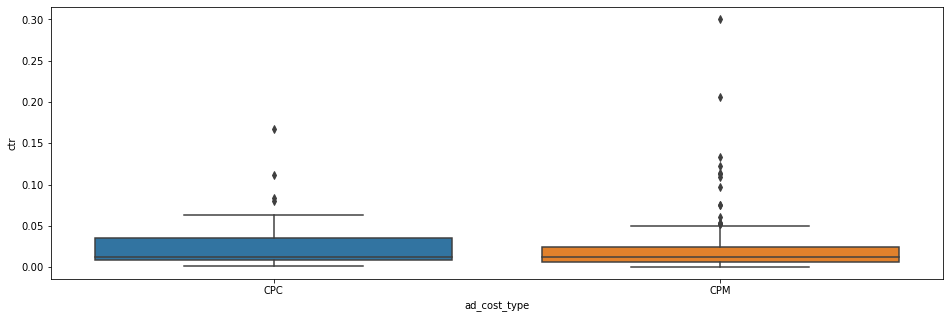

In [8]:
#Визуализируем данные CTR для CPC и CPM

plt.figure(figsize=(16,5))
sns.boxplot(x='ad_cost_type', y = 'ctr', data = cost_df)


#Наблюдаем ассиметричные распределения 

In [9]:
#Оцениваем средние значения ctr для разных типов оплаты рекламы

cost_df.groupby('ad_cost_type',as_index=False).agg({'ctr':'mean'})


#ВОПРОС: Это разница статистически значимая или нет?


,ad_cost_type,ctr
0,CPC,0.026160
1,CPM,0.021407


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr', ylabel='Density'>

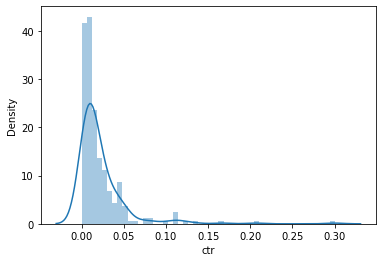

In [10]:
#Визуаилизируем распределение ctr  - наблюдаем ненормальное распределение

sns.distplot(cost_df.ctr)

#т.к распределение ненормально, мы не можем их сравнивать классическим t-тестом
#возможно единичные выборсы в CPC/CPM дали такое значение CTR

In [11]:
#Не можем использовать t-test, потому что распределения ненормальные (можем - но с большой осторожностью)
#НО! они - log-нормальные
# если использовать натуральный логорифм(означает - по основанию 2) - то он сглаживает значения(штрафует большие значения)

#Для лог - не должно быть нулевых(0) значений (добавляем в [30]строке - доп. усолвие(click>0))


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr', ylabel='Density'>

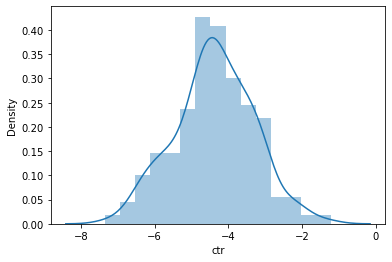

In [12]:
#Теперь визуализируем логарифм распределения ctr

sns.distplot(np.log(cost_df.ctr))

In [13]:
#Вывод: При ассимитричных выборках - логарифмируем для сглаживания, чтобы после этого уже проводить t-test

In [14]:
cost_df.head()

,ad_id,ad_cost_type,click,view,ctr
0,3,CPC,9.0,490.0,0.018367
2,2276,CPC,2.0,1454.0,0.001376
4,2643,CPM,3.0,286.0,0.010490
5,4585,CPC,53.0,476.0,0.111345
6,4877,CPC,5.0,2160.0,0.002315


In [15]:
cost_df = cost_df.assign(ctr_log = np.log(cost_df.ctr))
cost_df

,ad_id,ad_cost_type,click,view,ctr,ctr_log
0,3,CPC,9.0,490.0,0.018367,-3.997181
2,2276,CPC,2.0,1454.0,0.001376,-6.588926
4,2643,CPM,3.0,286.0,0.010490,-4.557380
5,4585,CPC,53.0,476.0,0.111345,-2.195126
6,4877,CPC,5.0,2160.0,0.002315,-6.068426
...,...,...,...,...,...,...
346,121541,CPM,8.0,274.0,0.029197,-3.533687
348,121779,CPC,447.0,7121.0,0.062772,-2.768245
349,121790,CPM,10.0,835.0,0.011976,-4.424847
351,121943,CPC,15.0,1722.0,0.008711,-4.743191


In [16]:
#Проводим тест Стьюдента

stats.ttest_ind(cost_df.query('ad_cost_type=="CPC"').ctr_log,
               cost_df.query('ad_cost_type=="CPM"').ctr_log)

#Если бы была верна Ho(ctr.mean для CPC и ctr.mean для CPM не отличаются),
#то вероятность таких различий между средними была бы 0.17 - НЕ ОТКЛОНЯЕМ H0, различия статистически не значимы 

Ttest_indResult(statistic=1.3629487968328853, pvalue=0.1740512902282947)

In [17]:
#Теперь делаем такие же рассчеты для платформы

df.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29


In [18]:
df.event.unique()

array(['view', 'click'], dtype=object)

In [19]:
df_platform = df.groupby(['ad_id','platform','event'],as_index=False) \
    .agg({'user_id':'count'})

In [20]:
df_platform.head()

,ad_id,platform,event,user_id
0,3,android,click,5
1,3,android,view,244
2,3,ios,click,3
3,3,ios,view,147
4,3,web,click,1


In [21]:
df_platform = df_platform.pivot(index=['ad_id','platform'],columns='event', values='user_id').reset_index()

In [22]:
df_platform

event,ad_id,platform,click,view
0,3,android,5.0,244.0
1,3,ios,3.0,147.0
2,3,web,1.0,99.0
3,2132,android,1.0,55.0
4,2132,ios,NaN,26.0
...,...,...,...,...
1059,122063,ios,NaN,73.0
1060,122063,web,NaN,61.0
1061,122086,android,26.0,1019.0
1062,122086,ios,16.0,599.0


In [23]:
df_platform = df_platform.groupby(['ad_id','platform'],as_index=False)\
    .agg({'click':'sum', 'view':'sum'}).fillna(0) \
    .query('view > 100 and click > 1')
df_platform.head()

,ad_id,platform,click,view
0,3,android,5.0,244.0
1,3,ios,3.0,147.0
6,2276,android,2.0,703.0
15,4585,android,17.0,224.0
16,4585,ios,24.0,148.0


In [24]:
df_platform = df_platform.assign(ctr = df_platform.click/df_platform.view)
df_platform.head()

,ad_id,platform,click,view,ctr
0,3,android,5.0,244.0,0.020492
1,3,ios,3.0,147.0,0.020408
6,2276,android,2.0,703.0,0.002845
15,4585,android,17.0,224.0,0.075893
16,4585,ios,24.0,148.0,0.162162


<AxesSubplot:xlabel='platform', ylabel='ctr'>

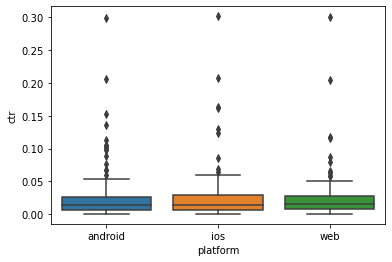

In [25]:
sns.boxplot(y = df_platform.ctr, x = df_platform.platform)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr', ylabel='Density'>

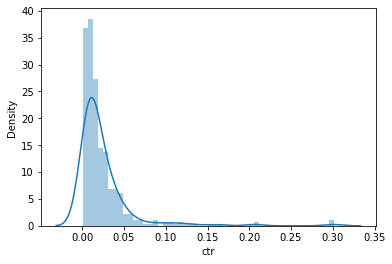

In [26]:
sns.distplot(df_platform.ctr)

In [32]:
df_platform['ctr_log'] = np.log(df_platform.ctr)
df_platform.head()

,ad_id,platform,click,view,ctr,ctr_log
0,3,android,5.0,244.0,0.020492,-3.887730
1,3,ios,3.0,147.0,0.020408,-3.891820
6,2276,android,2.0,703.0,0.002845,-5.862210
15,4585,android,17.0,224.0,0.075893,-2.578433
16,4585,ios,24.0,148.0,0.162162,-1.819158


<AxesSubplot:xlabel='platform', ylabel='ctr_log'>

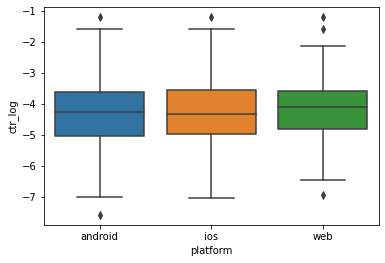

In [30]:
sns.boxplot(y = df_platform.ctr_log, x = df_platform.platform)

In [35]:
df_platform.groupby(['platform']).ctr.mean().reset_index()

#Ho - Различия между средними значениями ctr - статистически незначимы 

#H1 - Разница между средними значениями ctr статистически значима 


,platform,ctr
0,android,0.023179
1,ios,0.024647
2,web,0.026302


In [36]:
df.platform.unique()

array(['android', 'ios', 'web'], dtype=object)

In [55]:
#Для более 2 групп - используется тест Фишера - если однофакторный дисперсионный анализ (anova -  для множества факторов) 
#H0 - ни одно из выборочных средних не отличается от другого (нет различий)
#H1 - средние хотя бы двух групп стат. значимо отличаются друг от друга 

f_oneway(df_platform.query('platform == "android"').ctr_log,
         df_platform.query('platform == "ios"').ctr_log,
         df_platform.query('platform == "web"').ctr_log)
#pvalue>0.05 - Не можем отвергнуть гипотезу о том, что различий нет 

F_onewayResult(statistic=0.930115756413088, pvalue=0.3952584574796334)